In [1]:
import pandas as pd
import math
import random
import numpy as np
import copy
import xlsxwriter
import matplotlib.pyplot as plt
import time

In [2]:
class Sol():
    def __init__(self):
        self.nodes_seq=None
        self.obj=None
        self.routes=None
        self.distance = None
        self.num_vehicle = None
        self.over_due = None
class Node():
    def __init__(self):
        self.id=0
        self.name=''
        self.seq_no=0
        self.x_coord=0
        self.y_coord=0
        self.demand=0
        self.left_time_window = 0
        self.right_time_window = 0
        self.service_time = 0
        self.distance_to_depot = 0
class Model():
    '''
    Model()类，存储算法参数
    params:
        best_sol:全局最优解，值类型为Sol()
        node_list:物理节点集合，值类型为Node()
        sol_list:种群，值类型为Sol()
        node_seq_no_list:物理节点映射id集合
        depot:车辆基地，值类型为Node()
        number_of_nods:需求节点数量
        opt_type"优化目标类型，0：最小车辆数，1：最小行驶距离
        vehicle_cap:车辆容量
        pc:交叉概率
        pm:突变概率
        n_select:优良个体选择数量
        popsize:种群规模
    '''
    def __init__(self):
        self.best_sol=None
        self.node_list=[]
        self.sol_list=[]
        self.node_seq_no_list=[]
        self.depot=None
        self.number_of_nodes=0
        self.opt_type=0
        self.vehicle_cap=0
        self.pc=0.5
        self.pm=0.2
        self.n_select=80
        self.popsize=100
        self.distance = None
        self.speed = 10
    
    def show_params(self):
        print("最优解：",self.best_sol)
        print("节点列表：",self.node_list)
        print("节点id列表:",self.node_seq_no_list)

In [3]:
def readXlsxFile(filepath,model):
    df = pd.read_excel(filepath)
    node_seq_no = -1
    for i in range(df.shape[0]):
        # 每次循环生成一个node类对象
        node=Node()
        # 从-1开始赋予id，仓库id为-1
        node.id=node_seq_no
        node.seq_no=node_seq_no
        node.x_coord= df['x_coord'][i]
        node.y_coord= df['y_coord'][i]
        node.demand=df['demand'][i]
        node.left_time_window = df['left_time_window'][i]
        node.right_time_window = df['right_time_window'][i]
        node.service_time = df['service_time'][i]
        if df['demand'][i] == 0:
            model.depot=node
        else:
            model.node_list.append(node)
            # 储存映射id，与excel表中的id不一致
            model.node_seq_no_list.append(node_seq_no)
        try:
            node.name=df['name'][i]
        except:
            pass
        # 如果有id号，尝试添加id
        try:
            node.id=df['id'][i]
        except:
            pass
        node_seq_no=node_seq_no+1
    model.number_of_nodes=len(model.node_list)

In [4]:
def genInitialSol(model,distance_type = 0,distance_matrix = None,distance_to_depot = None):
    '''
    遗传算法初始化，生成初始种群
    '''
    # 深度拷贝节点列表，独立出一个nodes_seq为一个节点列表
    nodes_seq=copy.deepcopy(model.node_seq_no_list)
    # popsize:种群规模
    # 生成种群
    for i in range(model.popsize):
        seed=int(random.randint(0,100))
        random.seed(seed)
        # 打乱节点顺序
        random.shuffle(nodes_seq)
        sol=Sol()
        sol.nodes_seq=copy.deepcopy(nodes_seq)
        # sol_list:种群，值类型为Sol()
        # 将新解加入种群
        model.sol_list.append(sol)
    
    # 初始化距离邻接矩阵
    model.distance = np.zeros((model.number_of_nodes,model.number_of_nodes))
    if distance_type == 0:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = np.sqrt((model.node_list[i].x_coord-model.depot.x_coord)**2+\
                            (model.node_list[i].y_coord-model.depot.y_coord)**2) 
            for j in range(i+1,model.number_of_nodes):
                d=np.sqrt((model.node_list[i].x_coord-model.node_list[j].x_coord)**2+\
                            (model.node_list[i].y_coord-model.node_list[j].y_coord)**2)
                model.distance[i,j]=d
                model.distance[j,i]=d
    elif distance_type == 1:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = np.abs(model.node_list[i].x_coord-model.depot.x_coord)+\
                            np.abs(model.node_list[i].y_coord-model.depot.y_coord)
            for j in range(i+1,model.number_of_nodes):
                d=np.abs(model.node_list[i].x_coord-model.node_list[j].x_coord)+\
                            np.abs(model.node_list[i].y_coord-model.node_list[j].y_coord)
                model.distance[i,j]=d
                model.distance[j,i]=d
    elif distance_type == 3:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = distance_to_depot[i]
        model.distance = distance_matrix

In [5]:
def splitRoutes(nodes_seq,model):
    num_vehicle = 0
    vehicle_routes = []
    route = []
    remained_cap = model.vehicle_cap
    # 计算仓库到该路线第一个配送点时间
    time_counter = 0
    over_due = 0
    
    for i in range(len(nodes_seq)):
        ### 第一层条件语句判断是否满足容量约束
        if remained_cap - model.node_list[nodes_seq[i]].demand >= 0:
            ## 第二层第一个条件语句判断路径是否为空，不为空则路径中已存在配送点
            if len(route)== 0:
                time_counter = model.node_list[nodes_seq[i]].distance_to_depot/model.speed
            else:
                time_counter+= model.distance[range(model.number_of_nodes).index(route[-1]),\
                                             range(model.number_of_nodes).index(nodes_seq[i])]/model.speed
            ## 第二层第二个条件语句计算到达时间与时间窗    
            if time_counter < model.node_list[nodes_seq[i]].left_time_window:
                #小于左时间窗，计时器从左时间窗起加服务时间
                time_counter = model.node_list[nodes_seq[i]].left_time_window + model.node_list[nodes_seq[i]].service_time
                route.append(nodes_seq[i])
                remained_cap = remained_cap - model.node_list[nodes_seq[i]].demand
            elif (time_counter >= model.node_list[nodes_seq[i]].left_time_window)&\
                                            (time_counter<=model.node_list[nodes_seq[i]].right_time_window):
                #大于左时间窗小于右时间窗，计时器自增服务时间
                time_counter += model.node_list[nodes_seq[i]].service_time
                route.append(nodes_seq[i])
                remained_cap = remained_cap - model.node_list[nodes_seq[i]].demand
            else:
                #超出时间窗
                if len(route)==0:
                    route.append(nodes_seq[i])
                    vehicle_routes.append(route)
                    over_due+=1
                    route = []
                else:
                    vehicle_routes.append(route)
                    route = [nodes_seq[i]]
                    time_counter = model.node_list[nodes_seq[i]].distance_to_depot
                    remained_cap = model.vehicle_cap - model.node_list[nodes_seq[i]].demand
                
        else:
            vehicle_routes.append(route)
            route = [nodes_seq[i]]
            time_counter = model.node_list[nodes_seq[i]].distance_to_depot/model.speed
            remained_cap = model.vehicle_cap - model.node_list[nodes_seq[i]].demand
            
    if len(route)>0:
        vehicle_routes.append(route)
    num_vehicle = len(vehicle_routes)
    return num_vehicle,vehicle_routes,over_due

In [6]:
def calDistance(route,model):
    distance=0
    for i in range(len(route)-1):
        distance += model.distance[route[i],route[i+1]]
    
    distance+=model.node_list[route[0]].distance_to_depot
    distance+=model.node_list[route[-1]].distance_to_depot
    return distance
def calFit(model,a=10,b=1):
    #calculate fit value：fit=Objmax-obj
    Objmax=-float('inf')
    best_sol=Sol()#record the local best solution
    best_sol.obj=float('inf')
    #计算目标函数
    for sol in model.sol_list:
        nodes_seq=sol.nodes_seq
        num_vehicle, vehicle_routes,over_due = splitRoutes(nodes_seq, model)
        if model.opt_type==0:
            distance=0
            for route in vehicle_routes:
                distance+=calDistance(route,model)
            sol.distance=distance
            sol.obj=num_vehicle
            sol.num_vehicle = num_vehicle
            sol.routes=vehicle_routes
            sol.over_due = over_due
            if sol.obj>Objmax:
                Objmax=sol.obj
            if sol.obj<best_sol.obj:
                best_sol=copy.deepcopy(sol)
        elif model.opt_type==1:
            distance=0
            for route in vehicle_routes:
                distance+=calDistance(route,model)
            sol.obj=distance
            sol.distance = distance
            sol.num_vehicle = num_vehicle
            sol.routes=vehicle_routes
            sol.over_due = over_due
            if sol.obj>Objmax:
                Objmax=sol.obj
            if sol.obj < best_sol.obj:
                best_sol = copy.deepcopy(sol)
        else:
            distance=0
            for route in vehicle_routes:
                distance+=calDistance(route,model)
            sol.obj=a*num_vehicle+b*distance
            sol.distance = distance
            sol.num_vehicle = num_vehicle
            sol.routes=vehicle_routes
            sol.over_due = over_due
            if sol.obj>Objmax:
                Objmax=sol.obj
            if sol.obj < best_sol.obj:
                best_sol = copy.deepcopy(sol)
    #calculate fit value
    for sol in model.sol_list:
        sol.fit=Objmax-sol.obj
    #update the global best solution
    if best_sol.obj<model.best_sol.obj:
        model.best_sol=best_sol
    #Binary tournament
def selectSol(model):
    sol_list=copy.deepcopy(model.sol_list)
    model.sol_list=[]
    for i in range(model.n_select):
        f1_index=random.randint(0,len(sol_list)-1)
        f2_index=random.randint(0,len(sol_list)-1)
        f1_fit=sol_list[f1_index].fit
        f2_fit=sol_list[f2_index].fit
        if f1_fit<f2_fit:
            model.sol_list.append(sol_list[f2_index])
        else:
            model.sol_list.append(sol_list[f1_index])
    #Order Crossover (OX)
def crossSol(model):
    sol_list=copy.deepcopy(model.sol_list)
    model.sol_list=[]
    while True:
        f1_index = random.randint(0, len(sol_list) - 1)
        f2_index = random.randint(0, len(sol_list) - 1)
        if f1_index!=f2_index:
            f1 = copy.deepcopy(sol_list[f1_index])
            f2 = copy.deepcopy(sol_list[f2_index])
            if random.random() <= model.pc:
                cro1_index=int(random.randint(0,model.number_of_nodes-1))
                cro2_index=int(random.randint(cro1_index,model.number_of_nodes-1))
                new_c1_f = []
                new_c1_m=f1.nodes_seq[cro1_index:cro2_index+1]
                new_c1_b = []
                new_c2_f = []
                new_c2_m=f2.nodes_seq[cro1_index:cro2_index+1]
                new_c2_b = []
                for index in range(model.number_of_nodes):
                    if len(new_c1_f)<cro1_index:
                        if f2.nodes_seq[index] not in new_c1_m:
                            new_c1_f.append(f2.nodes_seq[index])
                    else:
                        if f2.nodes_seq[index] not in new_c1_m:
                            new_c1_b.append(f2.nodes_seq[index])
                for index in range(model.number_of_nodes):
                    if len(new_c2_f)<cro1_index:
                        if f1.nodes_seq[index] not in new_c2_m:
                            new_c2_f.append(f1.nodes_seq[index])
                    else:
                        if f1.nodes_seq[index] not in new_c2_m:
                            new_c2_b.append(f1.nodes_seq[index])
                new_c1=copy.deepcopy(new_c1_f)
                new_c1.extend(new_c1_m)
                new_c1.extend(new_c1_b)
                f1.nodes_seq=new_c1
                new_c2=copy.deepcopy(new_c2_f)
                new_c2.extend(new_c2_m)
                new_c2.extend(new_c2_b)
                f2.nodes_seq=new_c2
                model.sol_list.append(copy.deepcopy(f1))
                model.sol_list.append(copy.deepcopy(f2))
            else:
                model.sol_list.append(copy.deepcopy(f1))
                model.sol_list.append(copy.deepcopy(f2))
            if len(model.sol_list)>model.popsize:
                break
    #mutation
def muSol(model):
    sol_list=copy.deepcopy(model.sol_list)
    model.sol_list=[]
    while True:
        f1_index = int(random.randint(0, len(sol_list) - 1))
        f1 = copy.deepcopy(sol_list[f1_index])
        m1_index=random.randint(0,model.number_of_nodes-1)
        m2_index=random.randint(0,model.number_of_nodes-1)
        if m1_index!=m2_index:
            if random.random() <= model.pm:
                node1=f1.nodes_seq[m1_index]
                f1.nodes_seq[m1_index]=f1.nodes_seq[m2_index]
                f1.nodes_seq[m2_index]=node1
                model.sol_list.append(copy.deepcopy(f1))
            else:
                model.sol_list.append(copy.deepcopy(f1))
            if len(model.sol_list)>model.popsize:
                break
def plotObj(obj_list):
    plt.rcParams['font.sans-serif'] = ['SimHei'] #show chinese
    plt.rcParams['axes.unicode_minus'] = False  # Show minus sign
    plt.plot(np.arange(1,len(obj_list)+1),obj_list)
    plt.xlabel('Iterations')
    plt.ylabel('Obj Value')
    plt.grid()
    plt.xlim(1,len(obj_list)+1)
    plt.show()
def outPut(model):
    work=xlsxwriter.Workbook('result.xlsx')
    worksheet=work.add_worksheet()
    worksheet.write(0,0,'opt_type')
    worksheet.write(1,0,'obj')
    if model.opt_type==0:
        worksheet.write(0,1,'number of vehicles')
    else:
        worksheet.write(0, 1, 'drive distance of vehicles')
    worksheet.write(1,1,model.best_sol.obj)
    for row,route in enumerate(model.best_sol.routes):
        worksheet.write(row+2,0,'v'+str(row+1))
        r=[str(model.node_list[i].id)for i in route]
        worksheet.write(row+2,1, '-'.join(r))
    work.close()


def run(filepath,epochs,pc,pm,popsize,n_select,v_cap,opt_type):
    """
    :param filepath:Xlsx file path
    :param epochs:Iterations
    :param pc:Crossover probability
    :param pm:Mutation probability
    :param popsize:Population size
    :param n_select:Number of excellent individuals selected
    :param v_cap:Vehicle capacity
    :param opt_type:Optimization type:0:Minimize the number of vehicles,1:Minimize travel distance
    :return:
    """
    model=Model()
    model.vehicle_cap=v_cap
    model.opt_type=opt_type
    model.pc=pc
    model.pm=pm
    model.popsize=popsize
    model.n_select=n_select

    readXlsxFile(filepath,model)
    genInitialSol(model)
    history_best_obj = []
    best_sol=Sol()
    best_sol.obj=float('inf')
    model.best_sol=best_sol
    for ep in range(epochs):
        calFit(model)
        selectSol(model)
        crossSol(model)
        muSol(model)
        history_best_obj.append(model.best_sol.obj)
        print("%s/%s， best obj: %s，num_vehicle: %s" % (ep,epochs,model.best_sol.obj,model.best_sol.num_vehicle))
    plotObj(history_best_obj)
    outPut(model)

0/3000， best obj: 4237.024742447695，num_vehicle: 37
1/3000， best obj: 4237.024742447695，num_vehicle: 37
2/3000， best obj: 4237.024742447695，num_vehicle: 37
3/3000， best obj: 4237.024742447695，num_vehicle: 37
4/3000， best obj: 4237.024742447695，num_vehicle: 37
5/3000， best obj: 4230.654824633937，num_vehicle: 37
6/3000， best obj: 4142.81739551244，num_vehicle: 35
7/3000， best obj: 4095.81672047491，num_vehicle: 36
8/3000， best obj: 4095.81672047491，num_vehicle: 36
9/3000， best obj: 4035.6811485736425，num_vehicle: 39
10/3000， best obj: 4035.6811485736425，num_vehicle: 39
11/3000， best obj: 4034.246621745202，num_vehicle: 38
12/3000， best obj: 4034.246621745202，num_vehicle: 38
13/3000， best obj: 4034.246621745202，num_vehicle: 38
14/3000， best obj: 4034.246621745202，num_vehicle: 38
15/3000， best obj: 4034.246621745202，num_vehicle: 38
16/3000， best obj: 3979.7990216458766，num_vehicle: 39
17/3000， best obj: 3979.7990216458766，num_vehicle: 39
18/3000， best obj: 3979.7990216458766，num_vehicle: 39
1

153/3000， best obj: 3119.3155491486013，num_vehicle: 32
154/3000， best obj: 3119.3155491486013，num_vehicle: 32
155/3000， best obj: 3119.3155491486013，num_vehicle: 32
156/3000， best obj: 3119.3155491486013，num_vehicle: 32
157/3000， best obj: 3119.3155491486013，num_vehicle: 32
158/3000， best obj: 3119.3155491486013，num_vehicle: 32
159/3000， best obj: 3119.3155491486013，num_vehicle: 32
160/3000， best obj: 3119.3155491486013，num_vehicle: 32
161/3000， best obj: 3119.3155491486013，num_vehicle: 32
162/3000， best obj: 3119.3155491486013，num_vehicle: 32
163/3000， best obj: 3116.488539659776，num_vehicle: 33
164/3000， best obj: 3108.3062126740124，num_vehicle: 32
165/3000， best obj: 3108.3062126740124，num_vehicle: 32
166/3000， best obj: 3108.3062126740124，num_vehicle: 32
167/3000， best obj: 3106.607420882251，num_vehicle: 32
168/3000， best obj: 3105.5497233928527，num_vehicle: 32
169/3000， best obj: 3096.2903618435666，num_vehicle: 33
170/3000， best obj: 3096.2903618435666，num_vehicle: 33
171/3000， be

305/3000， best obj: 2828.552981155581，num_vehicle: 27
306/3000， best obj: 2828.552981155581，num_vehicle: 27
307/3000， best obj: 2828.552981155581，num_vehicle: 27
308/3000， best obj: 2828.552981155581，num_vehicle: 27
309/3000， best obj: 2828.552981155581，num_vehicle: 27
310/3000， best obj: 2826.528828208184，num_vehicle: 27
311/3000， best obj: 2826.528828208184，num_vehicle: 27
312/3000， best obj: 2826.528828208184，num_vehicle: 27
313/3000， best obj: 2826.528828208184，num_vehicle: 27
314/3000， best obj: 2809.2737406502306，num_vehicle: 27
315/3000， best obj: 2809.2737406502306，num_vehicle: 27
316/3000， best obj: 2800.0053909303683，num_vehicle: 27
317/3000， best obj: 2800.0053909303683，num_vehicle: 27
318/3000， best obj: 2800.0053909303683，num_vehicle: 27
319/3000， best obj: 2800.0053909303683，num_vehicle: 27
320/3000， best obj: 2800.0053909303683，num_vehicle: 27
321/3000， best obj: 2800.0053909303683，num_vehicle: 27
322/3000， best obj: 2800.0053909303683，num_vehicle: 27
323/3000， best obj:

456/3000， best obj: 2591.3947992388576，num_vehicle: 28
457/3000， best obj: 2591.3947992388576，num_vehicle: 28
458/3000， best obj: 2591.3947992388576，num_vehicle: 28
459/3000， best obj: 2591.3947992388576，num_vehicle: 28
460/3000， best obj: 2591.3947992388576，num_vehicle: 28
461/3000， best obj: 2591.3947992388576，num_vehicle: 28
462/3000， best obj: 2591.3947992388576，num_vehicle: 28
463/3000， best obj: 2589.658629874451，num_vehicle: 28
464/3000， best obj: 2573.733716409275，num_vehicle: 28
465/3000， best obj: 2573.733716409275，num_vehicle: 28
466/3000， best obj: 2573.4658897459362，num_vehicle: 28
467/3000， best obj: 2573.4658897459362，num_vehicle: 28
468/3000， best obj: 2573.4658897459362，num_vehicle: 28
469/3000， best obj: 2570.6166706193853，num_vehicle: 28
470/3000， best obj: 2570.6166706193853，num_vehicle: 28
471/3000， best obj: 2570.6166706193853，num_vehicle: 28
472/3000， best obj: 2560.8605774052994，num_vehicle: 29
473/3000， best obj: 2560.8605774052994，num_vehicle: 29
474/3000， bes

607/3000， best obj: 2446.6829813346058，num_vehicle: 28
608/3000， best obj: 2446.6829813346058，num_vehicle: 28
609/3000， best obj: 2446.6829813346058，num_vehicle: 28
610/3000， best obj: 2446.6829813346058，num_vehicle: 28
611/3000， best obj: 2446.6829813346058，num_vehicle: 28
612/3000， best obj: 2446.6829813346058，num_vehicle: 28
613/3000， best obj: 2446.6829813346058，num_vehicle: 28
614/3000， best obj: 2446.6829813346058，num_vehicle: 28
615/3000， best obj: 2446.6829813346058，num_vehicle: 28
616/3000， best obj: 2446.6829813346058，num_vehicle: 28
617/3000， best obj: 2446.6829813346058，num_vehicle: 28
618/3000， best obj: 2446.6829813346058，num_vehicle: 28
619/3000， best obj: 2446.6829813346058，num_vehicle: 28
620/3000， best obj: 2446.6829813346058，num_vehicle: 28
621/3000， best obj: 2446.6829813346058，num_vehicle: 28
622/3000， best obj: 2441.7364410152923，num_vehicle: 28
623/3000， best obj: 2441.7364410152923，num_vehicle: 28
624/3000， best obj: 2441.7364410152923，num_vehicle: 28
625/3000， 

759/3000， best obj: 2339.9352976241453，num_vehicle: 28
760/3000， best obj: 2339.9352976241453，num_vehicle: 28
761/3000， best obj: 2333.1754135411657，num_vehicle: 28
762/3000， best obj: 2333.1754135411657，num_vehicle: 28
763/3000， best obj: 2333.1754135411657，num_vehicle: 28
764/3000， best obj: 2333.1754135411657，num_vehicle: 28
765/3000， best obj: 2333.1754135411657，num_vehicle: 28
766/3000， best obj: 2333.1754135411657，num_vehicle: 28
767/3000， best obj: 2333.1754135411657，num_vehicle: 28
768/3000， best obj: 2333.1754135411657，num_vehicle: 28
769/3000， best obj: 2330.5482085029444，num_vehicle: 28
770/3000， best obj: 2330.5482085029444，num_vehicle: 28
771/3000， best obj: 2330.5482085029444，num_vehicle: 28
772/3000， best obj: 2330.5482085029444，num_vehicle: 28
773/3000， best obj: 2330.5482085029444，num_vehicle: 28
774/3000， best obj: 2330.5482085029444，num_vehicle: 28
775/3000， best obj: 2328.749749223085，num_vehicle: 28
776/3000， best obj: 2328.749749223085，num_vehicle: 28
777/3000， be

909/3000， best obj: 2279.8201232161855，num_vehicle: 28
910/3000， best obj: 2279.8201232161855，num_vehicle: 28
911/3000， best obj: 2279.8201232161855，num_vehicle: 28
912/3000， best obj: 2279.8201232161855，num_vehicle: 28
913/3000， best obj: 2279.8201232161855，num_vehicle: 28
914/3000， best obj: 2279.8201232161855，num_vehicle: 28
915/3000， best obj: 2279.8201232161855，num_vehicle: 28
916/3000， best obj: 2279.8201232161855，num_vehicle: 28
917/3000， best obj: 2279.8201232161855，num_vehicle: 28
918/3000， best obj: 2279.8201232161855，num_vehicle: 28
919/3000， best obj: 2279.8201232161855，num_vehicle: 28
920/3000， best obj: 2279.8201232161855，num_vehicle: 28
921/3000， best obj: 2279.8201232161855，num_vehicle: 28
922/3000， best obj: 2279.8201232161855，num_vehicle: 28
923/3000， best obj: 2279.8201232161855，num_vehicle: 28
924/3000， best obj: 2279.8201232161855，num_vehicle: 28
925/3000， best obj: 2279.8201232161855，num_vehicle: 28
926/3000， best obj: 2279.8201232161855，num_vehicle: 28
927/3000， 

1060/3000， best obj: 2255.118021766937，num_vehicle: 28
1061/3000， best obj: 2255.118021766937，num_vehicle: 28
1062/3000， best obj: 2255.118021766937，num_vehicle: 28
1063/3000， best obj: 2253.3167857885933，num_vehicle: 28
1064/3000， best obj: 2253.3167857885933，num_vehicle: 28
1065/3000， best obj: 2253.3167857885933，num_vehicle: 28
1066/3000， best obj: 2253.3167857885933，num_vehicle: 28
1067/3000， best obj: 2253.3167857885933，num_vehicle: 28
1068/3000， best obj: 2253.3167857885933，num_vehicle: 28
1069/3000， best obj: 2253.3167857885933，num_vehicle: 28
1070/3000， best obj: 2253.3167857885933，num_vehicle: 28
1071/3000， best obj: 2253.3167857885933，num_vehicle: 28
1072/3000， best obj: 2253.3167857885933，num_vehicle: 28
1073/3000， best obj: 2253.3167857885933，num_vehicle: 28
1074/3000， best obj: 2253.3167857885933，num_vehicle: 28
1075/3000， best obj: 2253.3167857885933，num_vehicle: 28
1076/3000， best obj: 2253.3167857885933，num_vehicle: 28
1077/3000， best obj: 2253.3167857885933，num_vehicle

1208/3000， best obj: 2196.058579100846，num_vehicle: 27
1209/3000， best obj: 2196.058579100846，num_vehicle: 27
1210/3000， best obj: 2196.058579100846，num_vehicle: 27
1211/3000， best obj: 2196.058579100846，num_vehicle: 27
1212/3000， best obj: 2196.058579100846，num_vehicle: 27
1213/3000， best obj: 2196.058579100846，num_vehicle: 27
1214/3000， best obj: 2196.058579100846，num_vehicle: 27
1215/3000， best obj: 2196.058579100846，num_vehicle: 27
1216/3000， best obj: 2196.058579100846，num_vehicle: 27
1217/3000， best obj: 2196.058579100846，num_vehicle: 27
1218/3000， best obj: 2196.058579100846，num_vehicle: 27
1219/3000， best obj: 2196.058579100846，num_vehicle: 27
1220/3000， best obj: 2196.058579100846，num_vehicle: 27
1221/3000， best obj: 2196.058579100846，num_vehicle: 27
1222/3000， best obj: 2196.058579100846，num_vehicle: 27
1223/3000， best obj: 2191.407499587164，num_vehicle: 27
1224/3000， best obj: 2191.407499587164，num_vehicle: 27
1225/3000， best obj: 2191.407499587164，num_vehicle: 27
1226/3000，

1357/3000， best obj: 2157.695948669101，num_vehicle: 26
1358/3000， best obj: 2157.695948669101，num_vehicle: 26
1359/3000， best obj: 2157.695948669101，num_vehicle: 26
1360/3000， best obj: 2157.695948669101，num_vehicle: 26
1361/3000， best obj: 2157.695948669101，num_vehicle: 26
1362/3000， best obj: 2157.695948669101，num_vehicle: 26
1363/3000， best obj: 2157.695948669101，num_vehicle: 26
1364/3000， best obj: 2157.695948669101，num_vehicle: 26
1365/3000， best obj: 2157.695948669101，num_vehicle: 26
1366/3000， best obj: 2157.695948669101，num_vehicle: 26
1367/3000， best obj: 2157.695948669101，num_vehicle: 26
1368/3000， best obj: 2157.695948669101，num_vehicle: 26
1369/3000， best obj: 2157.695948669101，num_vehicle: 26
1370/3000， best obj: 2157.695948669101，num_vehicle: 26
1371/3000， best obj: 2157.695948669101，num_vehicle: 26
1372/3000， best obj: 2157.695948669101，num_vehicle: 26
1373/3000， best obj: 2157.695948669101，num_vehicle: 26
1374/3000， best obj: 2157.695948669101，num_vehicle: 26
1375/3000，

1506/3000， best obj: 2093.6932953519495，num_vehicle: 26
1507/3000， best obj: 2093.6932953519495，num_vehicle: 26
1508/3000， best obj: 2093.6932953519495，num_vehicle: 26
1509/3000， best obj: 2093.6932953519495，num_vehicle: 26
1510/3000， best obj: 2093.6932953519495，num_vehicle: 26
1511/3000， best obj: 2093.6932953519495，num_vehicle: 26
1512/3000， best obj: 2093.6932953519495，num_vehicle: 26
1513/3000， best obj: 2093.6932953519495，num_vehicle: 26
1514/3000， best obj: 2093.6932953519495，num_vehicle: 26
1515/3000， best obj: 2093.6932953519495，num_vehicle: 26
1516/3000， best obj: 2093.6932953519495，num_vehicle: 26
1517/3000， best obj: 2093.6932953519495，num_vehicle: 26
1518/3000， best obj: 2093.6932953519495，num_vehicle: 26
1519/3000， best obj: 2093.6932953519495，num_vehicle: 26
1520/3000， best obj: 2093.6932953519495，num_vehicle: 26
1521/3000， best obj: 2093.6932953519495，num_vehicle: 26
1522/3000， best obj: 2093.6932953519495，num_vehicle: 26
1523/3000， best obj: 2093.6932953519495，num_vehi

1653/3000， best obj: 2093.6932953519495，num_vehicle: 26
1654/3000， best obj: 2093.6932953519495，num_vehicle: 26
1655/3000， best obj: 2093.6932953519495，num_vehicle: 26
1656/3000， best obj: 2093.6932953519495，num_vehicle: 26
1657/3000， best obj: 2093.6932953519495，num_vehicle: 26
1658/3000， best obj: 2093.6932953519495，num_vehicle: 26
1659/3000， best obj: 2093.6932953519495，num_vehicle: 26
1660/3000， best obj: 2093.6932953519495，num_vehicle: 26
1661/3000， best obj: 2093.6932953519495，num_vehicle: 26
1662/3000， best obj: 2093.6932953519495，num_vehicle: 26
1663/3000， best obj: 2093.6932953519495，num_vehicle: 26
1664/3000， best obj: 2093.6932953519495，num_vehicle: 26
1665/3000， best obj: 2093.6932953519495，num_vehicle: 26
1666/3000， best obj: 2093.6932953519495，num_vehicle: 26
1667/3000， best obj: 2093.6932953519495，num_vehicle: 26
1668/3000， best obj: 2093.6932953519495，num_vehicle: 26
1669/3000， best obj: 2093.6932953519495，num_vehicle: 26
1670/3000， best obj: 2093.6932953519495，num_vehi

1801/3000， best obj: 2056.417981555709，num_vehicle: 25
1802/3000， best obj: 2056.417981555709，num_vehicle: 25
1803/3000， best obj: 2056.417981555709，num_vehicle: 25
1804/3000， best obj: 2056.417981555709，num_vehicle: 25
1805/3000， best obj: 2056.417981555709，num_vehicle: 25
1806/3000， best obj: 2056.417981555709，num_vehicle: 25
1807/3000， best obj: 2056.417981555709，num_vehicle: 25
1808/3000， best obj: 2056.417981555709，num_vehicle: 25
1809/3000， best obj: 2056.417981555709，num_vehicle: 25
1810/3000， best obj: 2056.417981555709，num_vehicle: 25
1811/3000， best obj: 2056.417981555709，num_vehicle: 25
1812/3000， best obj: 2056.417981555709，num_vehicle: 25
1813/3000， best obj: 2056.417981555709，num_vehicle: 25
1814/3000， best obj: 2056.417981555709，num_vehicle: 25
1815/3000， best obj: 2056.417981555709，num_vehicle: 25
1816/3000， best obj: 2056.417981555709，num_vehicle: 25
1817/3000， best obj: 2056.417981555709，num_vehicle: 25
1818/3000， best obj: 2056.417981555709，num_vehicle: 25
1819/3000，

1950/3000， best obj: 1983.2882337611913，num_vehicle: 25
1951/3000， best obj: 1983.2882337611913，num_vehicle: 25
1952/3000， best obj: 1983.2882337611913，num_vehicle: 25
1953/3000， best obj: 1983.2882337611913，num_vehicle: 25
1954/3000， best obj: 1983.2882337611913，num_vehicle: 25
1955/3000， best obj: 1983.2882337611913，num_vehicle: 25
1956/3000， best obj: 1983.2882337611913，num_vehicle: 25
1957/3000， best obj: 1983.2882337611913，num_vehicle: 25
1958/3000， best obj: 1983.2882337611913，num_vehicle: 25
1959/3000， best obj: 1983.2882337611913，num_vehicle: 25
1960/3000， best obj: 1983.2882337611913，num_vehicle: 25
1961/3000， best obj: 1983.2882337611913，num_vehicle: 25
1962/3000， best obj: 1983.2882337611913，num_vehicle: 25
1963/3000， best obj: 1983.2882337611913，num_vehicle: 25
1964/3000， best obj: 1983.2882337611913，num_vehicle: 25
1965/3000， best obj: 1983.2882337611913，num_vehicle: 25
1966/3000， best obj: 1983.2882337611913，num_vehicle: 25
1967/3000， best obj: 1983.2882337611913，num_vehi

2098/3000， best obj: 1971.2510945458826，num_vehicle: 25
2099/3000， best obj: 1971.2510945458826，num_vehicle: 25
2100/3000， best obj: 1971.2510945458826，num_vehicle: 25
2101/3000， best obj: 1971.2510945458826，num_vehicle: 25
2102/3000， best obj: 1971.2510945458826，num_vehicle: 25
2103/3000， best obj: 1971.2510945458826，num_vehicle: 25
2104/3000， best obj: 1971.2510945458826，num_vehicle: 25
2105/3000， best obj: 1971.2510945458826，num_vehicle: 25
2106/3000， best obj: 1971.2510945458826，num_vehicle: 25
2107/3000， best obj: 1971.2510945458826，num_vehicle: 25
2108/3000， best obj: 1971.2510945458826，num_vehicle: 25
2109/3000， best obj: 1971.2510945458826，num_vehicle: 25
2110/3000， best obj: 1971.2510945458826，num_vehicle: 25
2111/3000， best obj: 1971.2510945458826，num_vehicle: 25
2112/3000， best obj: 1971.2510945458826，num_vehicle: 25
2113/3000， best obj: 1971.2510945458826，num_vehicle: 25
2114/3000， best obj: 1971.2510945458826，num_vehicle: 25
2115/3000， best obj: 1971.2510945458826，num_vehi

2246/3000， best obj: 1961.3480392583435，num_vehicle: 25
2247/3000， best obj: 1961.3480392583435，num_vehicle: 25
2248/3000， best obj: 1961.3480392583435，num_vehicle: 25
2249/3000， best obj: 1961.3480392583435，num_vehicle: 25
2250/3000， best obj: 1961.3480392583435，num_vehicle: 25
2251/3000， best obj: 1961.3480392583435，num_vehicle: 25
2252/3000， best obj: 1961.3480392583435，num_vehicle: 25
2253/3000， best obj: 1961.3480392583435，num_vehicle: 25
2254/3000， best obj: 1961.3480392583435，num_vehicle: 25
2255/3000， best obj: 1961.3480392583435，num_vehicle: 25
2256/3000， best obj: 1961.3480392583435，num_vehicle: 25
2257/3000， best obj: 1961.3480392583435，num_vehicle: 25
2258/3000， best obj: 1961.3480392583435，num_vehicle: 25
2259/3000， best obj: 1961.3480392583435，num_vehicle: 25
2260/3000， best obj: 1961.3480392583435，num_vehicle: 25
2261/3000， best obj: 1961.3480392583435，num_vehicle: 25
2262/3000， best obj: 1961.3480392583435，num_vehicle: 25
2263/3000， best obj: 1961.3480392583435，num_vehi

2393/3000， best obj: 1944.443823339749，num_vehicle: 25
2394/3000， best obj: 1944.443823339749，num_vehicle: 25
2395/3000， best obj: 1944.443823339749，num_vehicle: 25
2396/3000， best obj: 1944.443823339749，num_vehicle: 25
2397/3000， best obj: 1944.443823339749，num_vehicle: 25
2398/3000， best obj: 1944.443823339749，num_vehicle: 25
2399/3000， best obj: 1944.443823339749，num_vehicle: 25
2400/3000， best obj: 1944.443823339749，num_vehicle: 25
2401/3000， best obj: 1944.443823339749，num_vehicle: 25
2402/3000， best obj: 1944.443823339749，num_vehicle: 25
2403/3000， best obj: 1944.443823339749，num_vehicle: 25
2404/3000， best obj: 1944.443823339749，num_vehicle: 25
2405/3000， best obj: 1944.443823339749，num_vehicle: 25
2406/3000， best obj: 1944.443823339749，num_vehicle: 25
2407/3000， best obj: 1944.443823339749，num_vehicle: 25
2408/3000， best obj: 1944.443823339749，num_vehicle: 25
2409/3000， best obj: 1944.443823339749，num_vehicle: 25
2410/3000， best obj: 1944.443823339749，num_vehicle: 25
2411/3000，

2541/3000， best obj: 1911.6249123857408，num_vehicle: 25
2542/3000， best obj: 1911.6249123857408，num_vehicle: 25
2543/3000， best obj: 1911.6249123857408，num_vehicle: 25
2544/3000， best obj: 1911.6249123857408，num_vehicle: 25
2545/3000， best obj: 1911.6249123857408，num_vehicle: 25
2546/3000， best obj: 1911.6249123857408，num_vehicle: 25
2547/3000， best obj: 1911.6249123857408，num_vehicle: 25
2548/3000， best obj: 1911.6249123857408，num_vehicle: 25
2549/3000， best obj: 1911.6249123857408，num_vehicle: 25
2550/3000， best obj: 1911.6249123857408，num_vehicle: 25
2551/3000， best obj: 1911.6249123857408，num_vehicle: 25
2552/3000， best obj: 1911.6249123857408，num_vehicle: 25
2553/3000， best obj: 1911.6249123857408，num_vehicle: 25
2554/3000， best obj: 1911.6249123857408，num_vehicle: 25
2555/3000， best obj: 1911.6249123857408，num_vehicle: 25
2556/3000， best obj: 1911.6249123857408，num_vehicle: 25
2557/3000， best obj: 1911.6249123857408，num_vehicle: 25
2558/3000， best obj: 1911.6249123857408，num_vehi

2688/3000， best obj: 1846.7836219021958，num_vehicle: 25
2689/3000， best obj: 1846.7836219021958，num_vehicle: 25
2690/3000， best obj: 1846.7836219021958，num_vehicle: 25
2691/3000， best obj: 1846.7836219021958，num_vehicle: 25
2692/3000， best obj: 1846.7836219021958，num_vehicle: 25
2693/3000， best obj: 1846.7836219021958，num_vehicle: 25
2694/3000， best obj: 1846.7836219021958，num_vehicle: 25
2695/3000， best obj: 1846.7836219021958，num_vehicle: 25
2696/3000， best obj: 1846.7836219021958，num_vehicle: 25
2697/3000， best obj: 1846.7836219021958，num_vehicle: 25
2698/3000， best obj: 1846.7836219021958，num_vehicle: 25
2699/3000， best obj: 1846.7836219021958，num_vehicle: 25
2700/3000， best obj: 1846.7836219021958，num_vehicle: 25
2701/3000， best obj: 1846.7836219021958，num_vehicle: 25
2702/3000， best obj: 1846.7836219021958，num_vehicle: 25
2703/3000， best obj: 1846.7836219021958，num_vehicle: 25
2704/3000， best obj: 1846.7836219021958，num_vehicle: 25
2705/3000， best obj: 1846.7836219021958，num_vehi

2835/3000， best obj: 1846.7836219021958，num_vehicle: 25
2836/3000， best obj: 1846.7836219021958，num_vehicle: 25
2837/3000， best obj: 1846.7836219021958，num_vehicle: 25
2838/3000， best obj: 1846.7836219021958，num_vehicle: 25
2839/3000， best obj: 1846.7836219021958，num_vehicle: 25
2840/3000， best obj: 1846.7836219021958，num_vehicle: 25
2841/3000， best obj: 1846.7836219021958，num_vehicle: 25
2842/3000， best obj: 1846.7836219021958，num_vehicle: 25
2843/3000， best obj: 1846.7836219021958，num_vehicle: 25
2844/3000， best obj: 1846.7836219021958，num_vehicle: 25
2845/3000， best obj: 1846.7836219021958，num_vehicle: 25
2846/3000， best obj: 1846.7836219021958，num_vehicle: 25
2847/3000， best obj: 1846.7836219021958，num_vehicle: 25
2848/3000， best obj: 1846.7836219021958，num_vehicle: 25
2849/3000， best obj: 1844.8335083005622，num_vehicle: 25
2850/3000， best obj: 1844.8335083005622，num_vehicle: 25
2851/3000， best obj: 1844.8335083005622，num_vehicle: 25
2852/3000， best obj: 1844.8335083005622，num_vehi

2983/3000， best obj: 1844.8335083005622，num_vehicle: 25
2984/3000， best obj: 1844.8335083005622，num_vehicle: 25
2985/3000， best obj: 1844.8335083005622，num_vehicle: 25
2986/3000， best obj: 1844.8335083005622，num_vehicle: 25
2987/3000， best obj: 1844.8335083005622，num_vehicle: 25
2988/3000， best obj: 1844.8335083005622，num_vehicle: 25
2989/3000， best obj: 1844.8335083005622，num_vehicle: 25
2990/3000， best obj: 1844.8335083005622，num_vehicle: 25
2991/3000， best obj: 1844.8335083005622，num_vehicle: 25
2992/3000， best obj: 1844.8335083005622，num_vehicle: 25
2993/3000， best obj: 1844.8335083005622，num_vehicle: 25
2994/3000， best obj: 1844.8335083005622，num_vehicle: 25
2995/3000， best obj: 1844.8335083005622，num_vehicle: 25
2996/3000， best obj: 1844.8335083005622，num_vehicle: 25
2997/3000， best obj: 1844.8335083005622，num_vehicle: 25
2998/3000， best obj: 1844.8335083005622，num_vehicle: 25
2999/3000， best obj: 1844.8335083005622，num_vehicle: 25


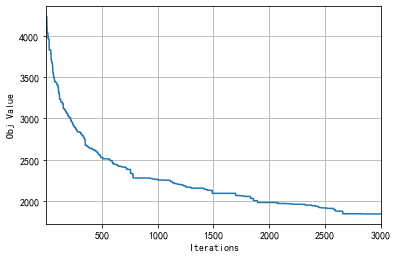

whole time: 404.1741199493408


In [7]:
start_time = time.time()
file='C:/Users/lisuc/Desktop/Algorithms_for_solving_VRP-master/data/c101.xlsx'
run(filepath=file,epochs=3000,pc=0.6,pm=0.2,popsize=100,n_select=80,v_cap=200,opt_type=1)
end_time = time.time()
print("whole time:",end_time - start_time)